# Requirement 4
Consider the different algorithms that we have seen for bidding and let them play one against the others in a *generalized first-price auction*. In particular, consider:
- A primal-dual algorithm for truthful auctions
- A primal-dual algorithm for non-truthful auctions
- A UCB-like approach

In [44]:
import numpy as np
#import jax.numpy as np
import matplotlib.pyplot as plt
import Configuration as config
from scipy import stats
from scipy import optimize
from tqdm import tqdm
from functools import wraps
import time
from scipy.optimize import curve_fit

### UCB-like algorithm

In [138]:
class UCB_agent:
    def __init__(self, B, T, prices, n_users, my_valuation, eta=0.1) -> None:
        self.B = B          # budget
        self.T = T          # number of rounds
        self.arms = prices  # arms of the UCB algorithm -> discretization of the prices
        self.eta = eta      # learning rate
        self.N_pulls = np.zeros(len(self.arms))     # number of pulls for each arm
        self.t = 0          # time step
        self.a_t = None     # arm played at time t
        self.rho = B/T      # budget per round
        self.n_users = n_users
        self.my_valuation = my_valuation         # CHOSEN RANDOMLY, CHECK
        self.budget_depleted = False
        self.average_rewards = np.zeros(len(self.arms))    # average rewards for each arm


    def action(self):
        # choose price to bid
        if self.B <= 1:
            if not self.budget_depleted:
                print('Budget depleted at round',self.t)
                self.budget_depleted = True
            self.a_t = 0        # cannot bid because the budget is depleted
        elif self.t < len(self.arms):     # have not pulled all arms yet
            self.a_t = self.arms[self.t]
        else:
            # arm choosen by UCB algorithm
            ucbs = self.average_rewards + np.sqrt(2*np.log(self.T)/self.N_pulls)
            self.a_t = self.arms[np.argmax(ucbs)]
       
        return self.a_t

    def update(self, f,c, bids_useless):
        arm_played_index = np.where(self.arms==self.a_t)[0][0]      # bad code to get the index of an element, no index() bc it is a numpy array
        self.N_pulls[arm_played_index] += 1    # we update the number of pulls for the arm played
        self.average_rewards[arm_played_index] += (f - self.average_rewards[arm_played_index])/self.N_pulls[arm_played_index]
        self.t += 1     # incresing time step
        self.B -= c     # updating the budget

### Primal-dual algorithm for truthful auctions 

In [46]:
class primal_dual_agent:
    def __init__(self, B, T, prices, my_valuation, eta=0.1):
        self.B = B
        self.T = T
        self.eta = eta
        self.rho = B/(T)
        self.v = my_valuation
        self.arms = prices
        self.a_t = None
        self.lambda_t = 0     # dual variable
        self.budget_depleted = False
    def action(self):
        # choose price to bid
        if self.B <= 1:
            if not self.budget_depleted:
                #print('Budget depleted at round',self.t)
                self.budget_depleted = True
            self.a_t = 0        # cannot bid because the budget is depleted
        else:
            self.a_t = self.v/(1+self.lambda_t)

        return self.a_t

    def update(self,f,c, bids_useless):
        self.lambda_t = max(0, min(self.lambda_t - self.eta*(self.rho - c), 1/self.rho))     # projection onto [0,1/rho]
        #self.t += 1     # incresing time step
        self.B -= c     # updating the budget

### Primal-dual algorithm for non-truthful auctions 

In [47]:
class HedgeAgent:
    def __init__(self, narms, learning_rate): #ho tolto il numero di slot da questa classe per tenere solo narms
        self.narms = narms   #number of possible bids
        self.learning_rate = learning_rate #supposing it's the rate at which the algorithm progress
        self.weights = np.ones(narms) #weight == proportionnal to the probabilty
        self.x_t = np.ones(narms)/narms #probability of a bid to be played
        self.a_t = None # bid choice done during the round
        self.t = 0

    def pull_arm(self): #choose which arm to play
        self.x_t = self.weights/sum(self.weights)
        self.a_t = np.random.choice(np.arange(self.narms), p=self.x_t)
        return self.a_t

    def update(self, l_t): #update the weights
        self.weights *= np.exp(-self.learning_rate*l_t)
        self.t += 1

In [48]:
def get_slot_won(bid, sorted_bids, n_slots):
    """Returns the slot won by the bid at a specific time-step"""
    for s in range(n_slots):
        if bid > sorted_bids[s]:
            return s
    return None
def get_bid_win_probabilities(bid, sorted_bids, lambdas):
    n_user = sorted_bids.shape[1]
    probabilities = np.zeros(len(lambdas))
    for u in range(n_user):
        slot = get_slot_won(bid, sorted_bids[:, u], len(lambdas))
        if slot is not None:
            probabilities[slot] += 1

    return probabilities/n_user

class FFMultiplicativePacingAgent:
    def __init__(self, bids_set, valuation, budget, T, eta, lambdas):
        self.bids_set = bids_set #available choices
        self.K = len(bids_set) # number of possible bids
        self.hedge = HedgeAgent(self.K, np.sqrt(np.log(self.K)/T))
        self.valuation = valuation #what you earn, ctr*profit_per_click
        self.budget = budget
        self.eta = eta #learning rate for the pacing, i.e. how much we update the pacing multiplier
        self.T = T  #number of rounds
        self.rho = self.budget/self.T #bid limit
        self.lmbd = 1 #pacing multiplier, when we spend more than rho it increses otherwise we decrease it
        self.t = 0
        self.lambdas = lambdas

    def action(self):
        if self.budget < 1:
            return 0
        return self.bids_set[self.hedge.pull_arm()]

    def update(self, f_t, c_t, sorted_bids):
        # update hedge
        f_t_full = np.zeros(self.K)
        c_t_full = np.zeros(self.K)
        for i, b in enumerate(self.bids_set): # full (expert) feedback
            if (get_slot_won(b, sorted_bids, len(self.lambdas)) is not None):
                f_t_full[i] = self.valuation*self.lambdas[get_slot_won(b, sorted_bids, len(self.lambdas))] - b
                c_t_full[i] = b
                
        L = f_t_full - self.lmbd*(c_t_full-self.rho)
        range_L = 2+(1-self.rho)/self.rho
        self.hedge.update((2-L)/range_L) # hedge needs losses in [0,1]
        # update lagrangian multiplier
        self.lmbd = np.clip(self.lmbd-self.eta*(self.rho-c_t),
                            a_min=0, a_max=1/self.rho)
        # update budget
        self.budget -= c_t

### Auctions classes

In [49]:
class Auction:
    def __init__(self, *args, **kwargs):
        pass

    def get_winners(self, bids):
        pass

    def get_payments_per_click(self, winners, values, bids):
        pass

    def round(self, bids):
        winners, values = self.get_winners(bids) # allocation mechanism!
        payments_per_click = self.get_payments_per_click(winners, values, bids)
        return winners, payments_per_click


In [50]:
class FirstPriceAuction(Auction):
    def __init__(self, ctrs, lambdas):
        self.ctrs = ctrs
        self.lambdas = lambdas
        self.n_adv = len(self.ctrs)
        self.n_slots = len(self.lambdas)
    
    def get_winners(self, bids):
        adv_values = self.ctrs*bids
        adv_ranking = np.argsort(adv_values) 
        winners = np.flip(adv_ranking[-self.n_slots:]) # important to flip the order from higher to lower
        winners_values = adv_values[winners]
        return winners, winners_values
    
    def get_payments_per_click(self, winners, values, bids):
        payment = np.array(bids)[winners]
        return payment.round(2)

# Simulation

In [136]:
def run_simulation(n_trials, auctions, n_users, n_arms, budget, lambdas, prices, valuation, bidding_env, eta, n_pd_truthful_agents, n_ucb_truthful_agents, n_pd_non_truthful_agents):
  n_tot_agents = n_pd_truthful_agents + n_ucb_truthful_agents + n_pd_non_truthful_agents
  ctrs = np.ones(n_tot_agents)
  
  # empty arrays for later logging
  utilities = np.empty((n_tot_agents, n_trials, auctions))
  bids = np.empty((n_tot_agents, n_trials, auctions))
  payments = np.empty((n_tot_agents, n_trials, auctions))
  total_wins_per_trial = np.zeros((n_tot_agents, n_trials))
  bidding_regret_per_trial = list()


  for trial in tqdm(range(n_trials)):
      # initialize empty arrays for agents
    pd_truthful_agents = []
    ucb_truthful_agents = []
    pd_non_truthful_agents = []

    '''need to create as many agents having different types as specified in the array configuration'''
    for i in range(n_pd_truthful_agents):
      pd_truthful_agents.append(primal_dual_agent(budget, auctions, prices, valuation, eta))   # auctions = n_iterations = T
    for i in range(n_ucb_truthful_agents):
      ucb_truthful_agents.append(UCB_agent(budget, auctions, prices, n_users, valuation))
    for i in range(n_pd_non_truthful_agents):
      pd_non_truthful_agents.append(FFMultiplicativePacingAgent(prices, valuation, budget, auctions, eta, lambdas))

    all_agents = pd_truthful_agents + ucb_truthful_agents + pd_non_truthful_agents    # concatenate all agents in a single array
    bse = bidding_env(ctrs,lambdas=lambdas)

    for auction in range(auctions):

        '''there is no more my bids, each agent has to decide how much to bid'''
        all_bids = [ba.action() for ba in all_agents]    # bidding agent decides how much to bid

        '''utility and cost computed for each agent''' 
        winners, payments_per_click = bse.round(bids=all_bids)    # somebody wins the auction
        '''winners = [] indexes of the winners in order
        payments_per_click = [] payments for each click of the winners in order'''
        
        '''each agent get its parameters updated'''
        f_t = np.zeros(n_tot_agents)
        c_t = np.zeros(n_tot_agents)
      

        for i,winner in enumerate(winners): 
          f_t[winner], c_t[winner] = (valuation-payments_per_click[i]), payments_per_click[i]
          all_agents[winner].update(f_t[winner],c_t[winner],np.sort(all_bids))
          total_wins_per_trial[winner, trial] += 1

        for j in range(n_tot_agents):
          if j not in winners:
            all_agents[j].update(0,0,np.sort(all_bids))

        ''' logging for each agent -> add a dimension to the arrays'''
        utilities[:, trial, auction] = f_t
        bids[:,trial, auction] = all_bids
        payments[:, trial, auction] = c_t
       

    '''compute regret for non-truthful auctions?'''

  fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(20,30))
  axs = axs.flatten()
  mean_wins_pd_truthful_agents = np.mean(total_wins_per_trial[:n_pd_truthful_agents, :], axis=1)
  mean_wins_ucb_truthful_agents = np.mean(total_wins_per_trial[n_pd_truthful_agents:n_pd_truthful_agents+n_ucb_truthful_agents, :], axis=1)
  mean_wins_pd_non_truthful_agents = np.mean(total_wins_per_trial[n_pd_truthful_agents+n_ucb_truthful_agents:, :], axis=1)
  print(mean_wins_pd_truthful_agents.shape)
  print(mean_wins_ucb_truthful_agents.shape)
  print(mean_wins_pd_non_truthful_agents.shape)
  sd_wins_pd_truthful_agents = np.std(total_wins_per_trial[:n_pd_truthful_agents, :], axis=1)
  sd_wins_ucb_truthful_agents = np.std(total_wins_per_trial[n_pd_truthful_agents:n_pd_truthful_agents+n_ucb_truthful_agents, :], axis=1)
  sd_wins_pd_non_truthful_agents = np.std(total_wins_per_trial[n_pd_truthful_agents+n_ucb_truthful_agents:, :], axis=1)
  axs[0].bar(np.arange(n_pd_truthful_agents), mean_wins_pd_truthful_agents, yerr=sd_wins_pd_truthful_agents, label='Primal-Dual Truthful')
  axs[0].bar(np.arange(n_pd_truthful_agents, n_pd_truthful_agents+n_ucb_truthful_agents), mean_wins_ucb_truthful_agents, yerr=sd_wins_ucb_truthful_agents, label='UCB Truthful')
  axs[0].bar(np.arange(n_pd_truthful_agents+n_ucb_truthful_agents, n_tot_agents), mean_wins_pd_non_truthful_agents, yerr=sd_wins_pd_non_truthful_agents, label='Primal-Dual Non-Truthful')
  axs[0].set_title('Wins per agent')
  axs[0].legend()


  mean_bid_pd_truthful_agents = np.mean(bids[:n_pd_truthful_agents, :, :], axis=0)
  mean_bid_ucb_truthful_agents = np.mean(bids[n_pd_truthful_agents:n_pd_truthful_agents+n_ucb_truthful_agents, :, :], axis=0)
  mean_bid_pd_non_truthful_agents = np.mean(bids[n_pd_truthful_agents+n_ucb_truthful_agents:, :, :], axis=0)
  sd_bid_pd_truthful_agents = np.std(bids[:n_pd_truthful_agents, :, :], axis=0)
  sd_bid_ucb_truthful_agents = np.std(bids[n_pd_truthful_agents:n_pd_truthful_agents+n_ucb_truthful_agents, :, :], axis=0)
  sd_bid_pd_non_truthful_agents = np.std(bids[n_pd_truthful_agents+n_ucb_truthful_agents:, :, :], axis=0)
  axs[1].plot(np.arange(auctions), np.mean(mean_bid_pd_truthful_agents, axis=0), label='Primal-Dual Truthful')
  axs[1].plot(np.arange(auctions), np.mean(mean_bid_ucb_truthful_agents, axis=0), label='UCB Truthful')
  axs[1].plot(np.arange(auctions), np.mean(mean_bid_pd_non_truthful_agents, axis=0), label='Primal-Dual Non-Truthful')
  axs[1].fill_between(np.arange(auctions), np.mean(mean_bid_pd_truthful_agents, axis=0)-np.mean(sd_bid_pd_truthful_agents, axis=0), np.mean(mean_bid_pd_truthful_agents, axis=0)+np.mean(sd_bid_pd_truthful_agents, axis=0), alpha=0.2)
  axs[1].fill_between(np.arange(auctions), np.mean(mean_bid_ucb_truthful_agents, axis=0)-np.mean(sd_bid_ucb_truthful_agents, axis=0), np.mean(mean_bid_ucb_truthful_agents, axis=0)+np.mean(sd_bid_ucb_truthful_agents, axis=0), alpha=0.2)
  axs[1].fill_between(np.arange(auctions), np.mean(mean_bid_pd_non_truthful_agents, axis=0)-np.mean(sd_bid_pd_non_truthful_agents, axis=0), np.mean(mean_bid_pd_non_truthful_agents, axis=0)+np.mean(sd_bid_pd_non_truthful_agents, axis=0), alpha=0.2)
  axs[1].legend()
  axs[1].set_title('Mean bids for each kind of agent')


  mean_payments_pd_truthful_agents = np.mean(payments[:n_pd_truthful_agents, :, :], axis=0)
  mean_payments_ucb_truthful_agents = np.mean(payments[n_pd_truthful_agents:n_pd_truthful_agents+n_ucb_truthful_agents, :, :], axis=0)
  mean_payments_pd_non_truthful_agents = np.mean(payments[n_pd_truthful_agents+n_ucb_truthful_agents:, :, :], axis=0)
  sd_payments_pd_truthful_agents = np.std(payments[:n_pd_truthful_agents, :, :], axis=0)
  sd_payments_ucb_truthful_agents = np.std(payments[n_pd_truthful_agents:n_pd_truthful_agents+n_ucb_truthful_agents, :, :], axis=0)
  sd_payments_pd_non_truthful_agents = np.std(payments[n_pd_truthful_agents+n_ucb_truthful_agents:, :, :], axis=0)
  print(np.mean(mean_payments_pd_truthful_agents, axis=0).shape)
  axs[2].plot(np.arange(auctions), np.cumsum(np.mean(mean_payments_pd_truthful_agents, axis=0)), label='Primal-Dual Truthful')
  axs[2].plot(np.arange(auctions), np.cumsum(np.mean(mean_payments_ucb_truthful_agents, axis=0)), label='UCB Truthful')
  axs[2].plot(np.arange(auctions), np.cumsum(np.mean(mean_payments_pd_non_truthful_agents, axis=0)), label='Primal-Dual Non-Truthful')
  axs[2].fill_between(np.arange(auctions), np.cumsum(np.mean(mean_payments_pd_truthful_agents, axis=0))-np.cumsum(np.mean(sd_payments_pd_truthful_agents, axis=0)), np.cumsum(np.mean(mean_payments_pd_truthful_agents, axis=0))+np.cumsum(np.mean(sd_payments_pd_truthful_agents, axis=0)), alpha=0.2)
  axs[2].fill_between(np.arange(auctions), np.cumsum(np.mean(mean_payments_ucb_truthful_agents, axis=0))-np.cumsum(np.mean(sd_payments_ucb_truthful_agents, axis=0)), np.cumsum(np.mean(mean_payments_ucb_truthful_agents, axis=0))+np.cumsum(np.mean(sd_payments_ucb_truthful_agents, axis=0)), alpha=0.2)
  axs[2].fill_between(np.arange(auctions), np.cumsum(np.mean(mean_payments_pd_non_truthful_agents, axis=0))-np.cumsum(np.mean(sd_payments_pd_non_truthful_agents, axis=0)), np.cumsum(np.mean(mean_payments_pd_non_truthful_agents, axis=0))+np.cumsum(np.mean(sd_payments_pd_non_truthful_agents, axis=0)), alpha=0.2)
  axs[2].legend()
  axs[2].axhline(y=budget, color='r', linestyle='--')
  axs[2].set_title('Mean payments for each kind of agent')
  return payments, bids, utilities, total_wins_per_trial


  0%|          | 0/1 [00:00<?, ?it/s]

Budget depleted at round 4123
Budget depleted at round 4886
Budget depleted at round 4895
Budget depleted at round 4988
Budget depleted at round 5000
Budget depleted at round 5015
Budget depleted at round 5068
Budget depleted at round 5086
Budget depleted at round 5136
Budget depleted at round 5155


100%|██████████| 1/1 [00:25<00:00, 25.79s/it]


(10,)
(10,)
(10,)
(10000,)


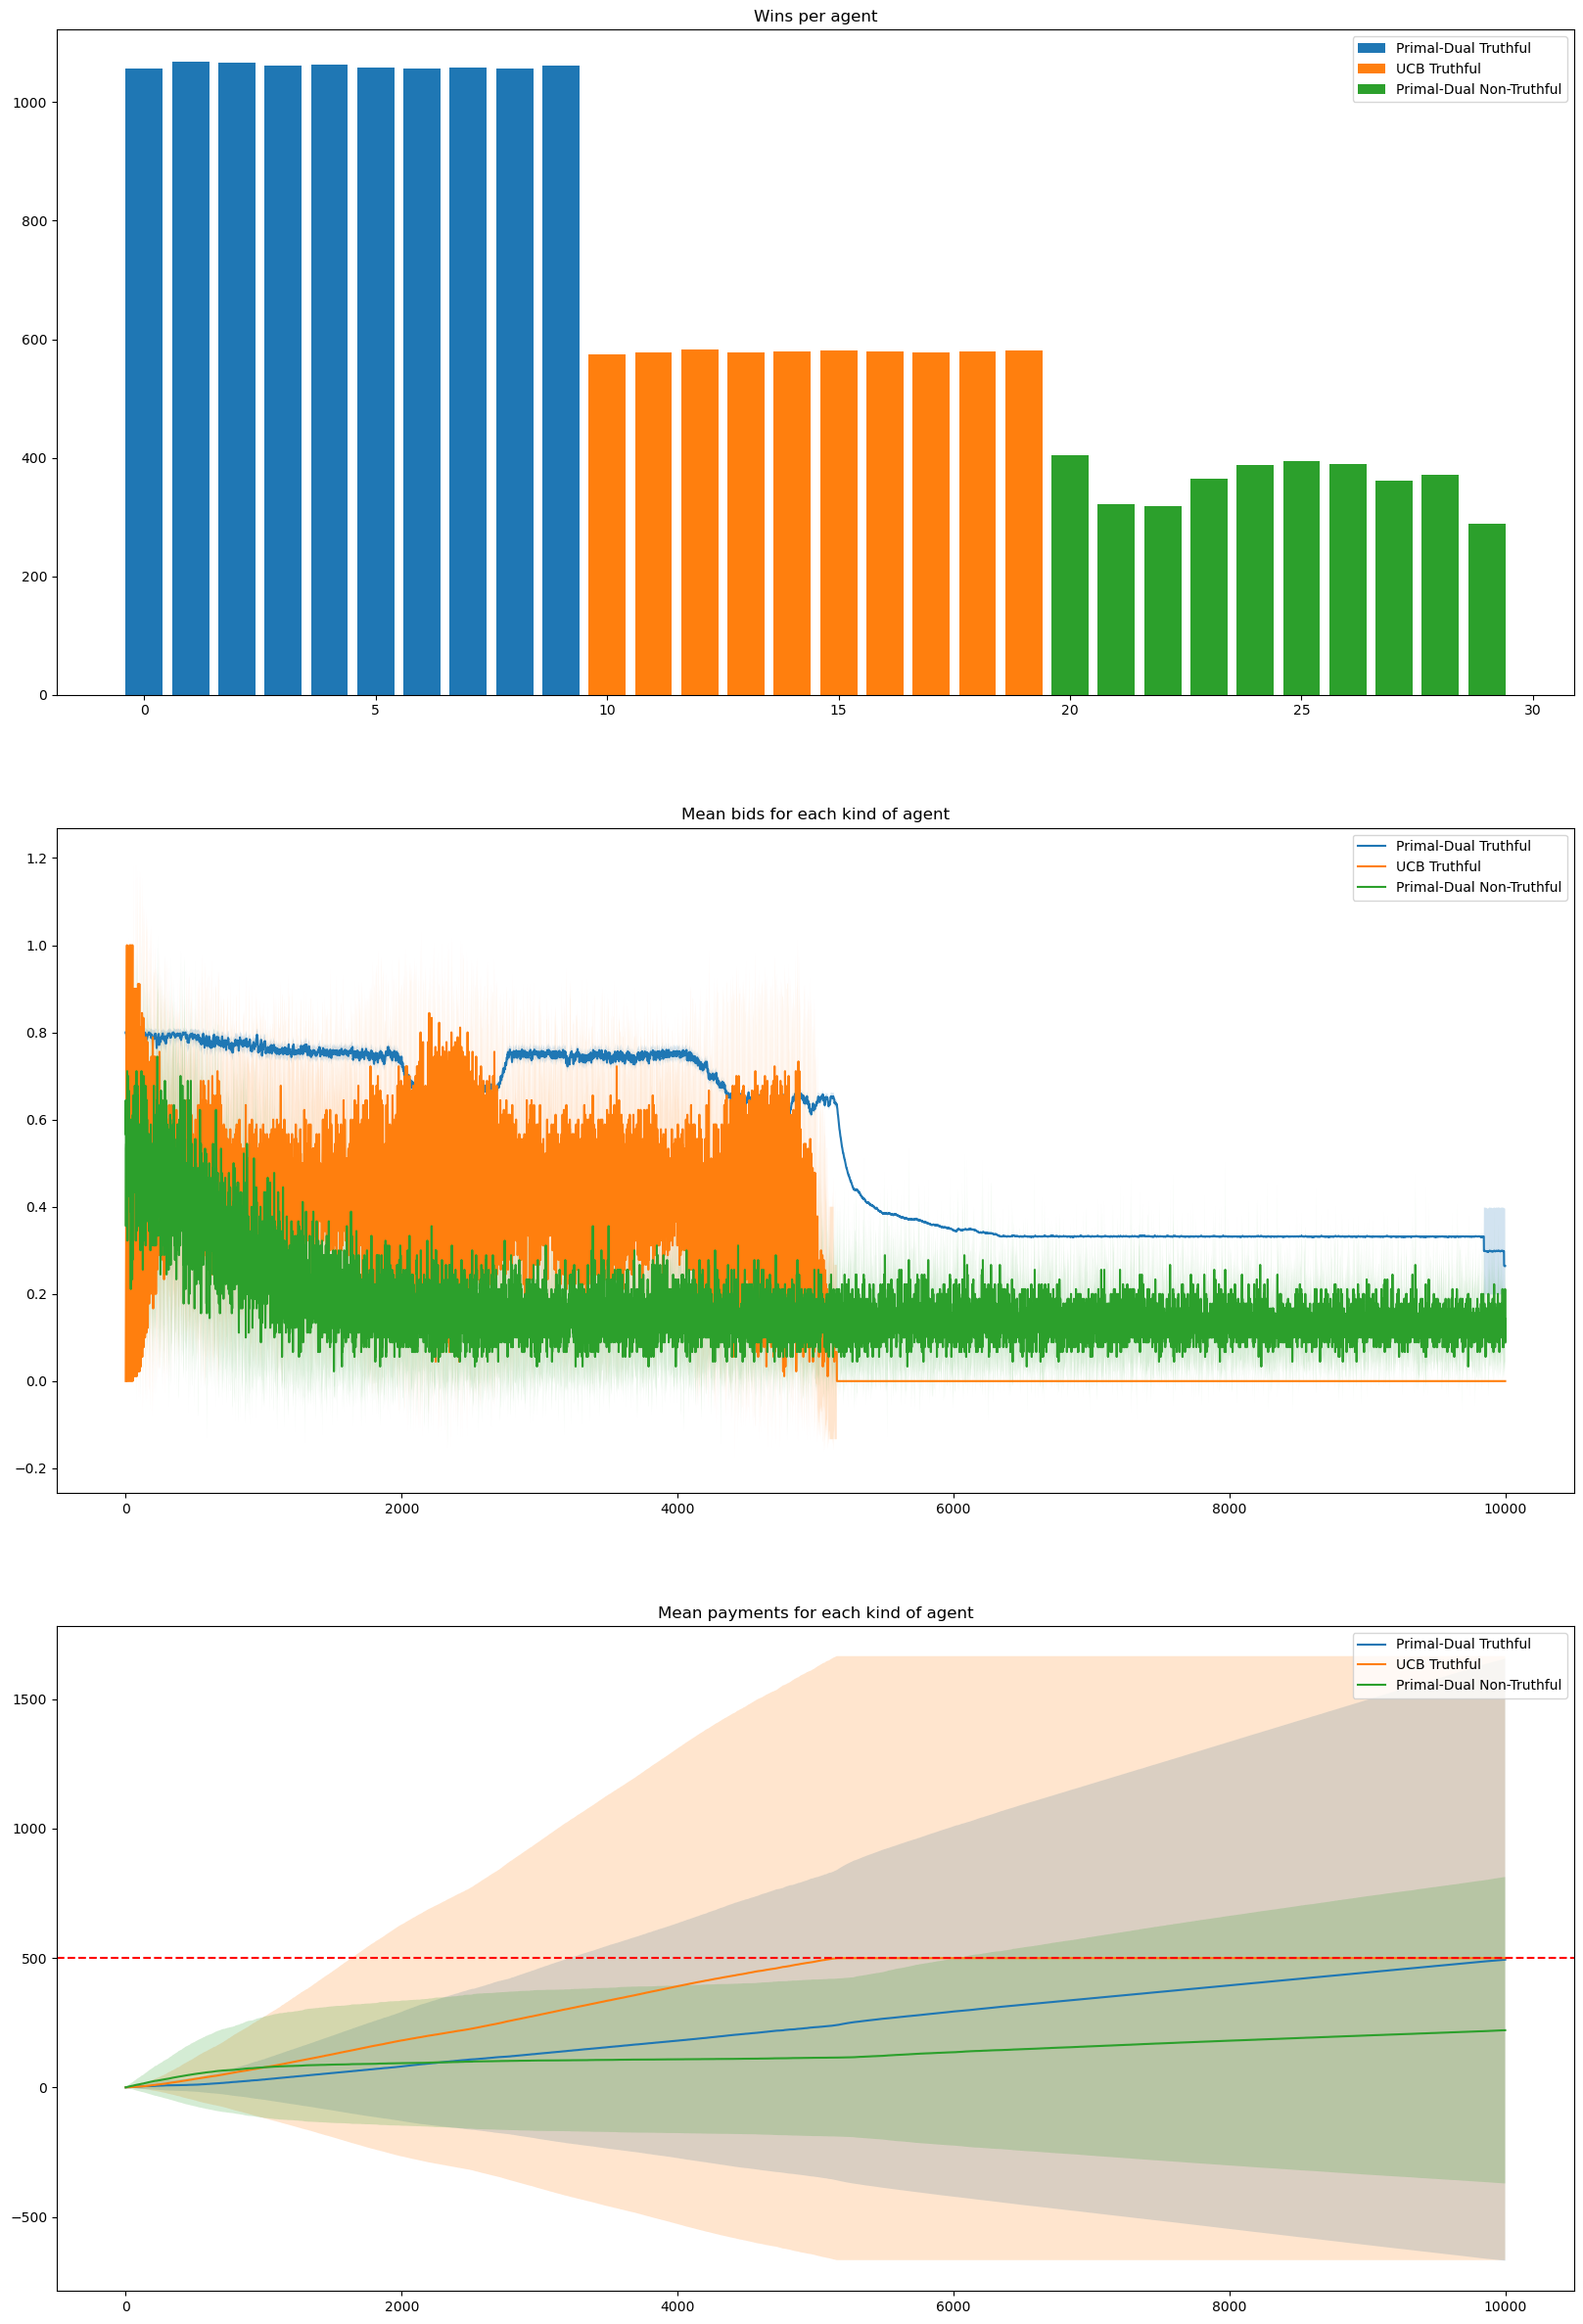

In [148]:
import importlib
importlib.reload(config)

NUMBER_OF_SLOTS = 2

lambda_fun_param = lambda s: 1/(s+(0.3))       # probability of the ad being seen given the position s ->  0.5 for first position, 0.33 for second, 0.25 for third, etc...
LAMBDAS = np.array([lambda_fun_param(i) for i in range(1, NUMBER_OF_SLOTS+1)])    # array of lambda values (for each slot)

ITERATIONS = 500#config.ITERATIONS
AUCTIONS = 10000 # config.AUCTIONS
N_USERS = config.N_USERS
NUMBER_OF_ARMS = 100 #config.NUMBER_OF_ARMS    # needed for the UCB algorithm
PRICES = config.PRICES    # actual arms of the ucb algorithm
BUDGET = 500 #config.BUDGET
LAMBDAS = np.flip(LAMBDAS)
N_TRIALS = 1

my_valuation = 0.6      # randomly chosen
cost = 0.2              # constant (for our purposes) cost of production

N_PD_TRUTHFUL_AGENTS=10
N_UCB_TRUTHFUL_AGENTS = 10
N_PD_NON_TRUTHFUL_AGENTS=10


payments, bids, utilities, total_wins_per_trial = run_simulation(n_trials = N_TRIALS,
               auctions = AUCTIONS,
               n_users = N_USERS,
               n_arms = NUMBER_OF_ARMS,
               budget = BUDGET,
               lambdas = LAMBDAS,
               prices = PRICES,
               valuation = 0.8,
               bidding_env=FirstPriceAuction,
               eta = 0.1,
               n_pd_truthful_agents=N_PD_TRUTHFUL_AGENTS,
               n_ucb_truthful_agents=N_UCB_TRUTHFUL_AGENTS,
               n_pd_non_truthful_agents=N_PD_NON_TRUTHFUL_AGENTS,
               )

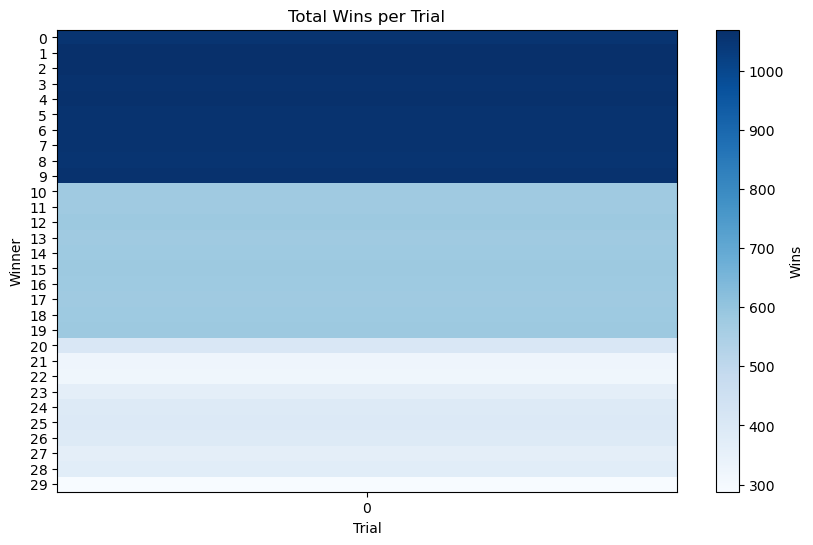

In [149]:
plt.figure(figsize=(10, 6))
plt.imshow(total_wins_per_trial, cmap='Blues', aspect='auto')
plt.colorbar(label='Wins')

plt.xlabel('Trial')
plt.ylabel('Winner')
plt.title('Total Wins per Trial')

plt.xticks(np.arange(total_wins_per_trial.shape[1]))
plt.yticks(np.arange(total_wins_per_trial.shape[0]))

plt.show()